In [1]:
import numpy as np
import pandas as pd

from pydantic import BaseModel, PydanticUserError
import scipy.integrate as integrate
from scipy.stats import cauchy
import matplotlib.pyplot as plt

In [2]:
class LiquidityProfile(BaseModel):
    """
    Generic model for concentrated liquidity global liquidity density function.
    
    Should require int_{-\infty}^{\infty} l(t)dt = C, where C is a global constant
    when no LPs add or remove funds from pool.

    Assumes continuous liquidity profile and input ticks are in "natural log" form
    such that price p = e ** (t), where t is the tick.
    """
    c: float

    def at(self, t: int) -> float:
        """
        `at` takes a tick value as input and returns the concentrated liquidity value
        in the pool.
        """
        raise PydanticUserError("Function not implemented.", code=None)

    def slip_y(self, t: int) -> float:
        """
        Tick slippage with respect to an infinitesimal amount of y.
        """
        return (2 / self.at(t)) * np.exp(-t/2)

    def slip_x(self, t: int) -> float:
        """
        Tick slippage with respect to an infinitesimal amount of x.
        """
        return - (2 / self.at(t)) * np.exp(t/2)

    def cost_y(self, i: int, f: int, rtol: float = 1e-8) -> float:
        """
        Amount of delta(y) in (+) or out (-) of pool to move pool tick
        from i -> f.

        Raises if relative error is > rtol input.
        """
        def integrand(t: int):
            return (self.at(t) / 2) * np.exp(t/2)

        (v, er) = integrate.quad(integrand, i, f)
        if er > rtol:
            raise ValueError(f'relative error of {er} exceed rtol of {rtol}.')

        return v

    def cost_x(self, i: int, f: int, rtol: float = 1e-8) -> float:
        """
        Amount of delta(x) in (+) or out (-) of pool to move pool tick
        from i -> f.

        Raises if relative error is > rtol input.
        """
        def integrand(t: int):
            return - (self.at(t) / 2) * np.exp(-t/2)

        (v, er) = integrate.quad(integrand, i, f)
        if er > rtol:
            raise ValueError(f'relative error of {er} exceed rtol of {rtol}.')

        return v

In [3]:
class CauchyLiquidityProfile(LiquidityProfile):
    """
    Cauchy distribution liquidity profile, with shape described by one scale parameter: gamma.

    l(t) = (c / (pi * gamma)) * (1 / (1 + (t / gamma) ** 2))
    """
    gamma: float

    def at(self, t: int) -> float:
        return self.c * cauchy.pdf(t, 0, self.gamma)

In [4]:
def from_bps_tick(tb: int) -> int:
    """
    Converts tick in bps form i.e. p = 1.0001 ** (tb)
    to tick in natural log form: p = e ** (t).
    """
    return np.log(1.0001) * tb

In [5]:
C = 10.0  # total liquidity parameter
GAMMA = 0.1  # scale parameter
MAX_TICK = 887272

In [6]:
clp = CauchyLiquidityProfile(c=C, gamma=GAMMA)

In [7]:
# should be c / (pi * gamma)
clp.at(0) == C / (np.pi * GAMMA)

True

In [8]:
# plot liquidity profile over ticks
bps_ticks = np.arange(start=-MAX_TICK, stop=MAX_TICK, step=10)
log_ticks = from_bps_tick(bps_ticks)
liquidities = clp.at(log_ticks)

In [9]:
df = pd.DataFrame(data={'bps_ticks': bps_ticks, 'log_ticks': log_ticks, f'l(t) [c={C}, g={GAMMA}]': liquidities})
df

,bps_ticks,log_ticks,"l(t) [c=10.0, g=0.1]"
0,-887272,-88.722764,0.00004
1,-887262,-88.721764,0.00004
2,-887252,-88.720764,0.00004
3,-887242,-88.719764,0.00004
4,-887232,-88.718764,0.00004
...,...,...,...
177450,887228,88.718364,0.00004
177451,887238,88.719364,0.00004
177452,887248,88.720364,0.00004
177453,887258,88.721364,0.00004


<Axes: xlabel='bps_ticks'>

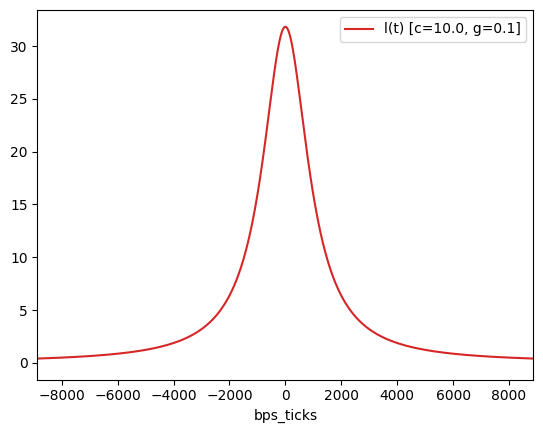

In [10]:
# plot +/- 60% 
df.plot(x='bps_ticks', y=f'l(t) [c={C}, g={GAMMA}]', xlim=(-MAX_TICK // 100, MAX_TICK // 100), color='C3')

In [11]:
# generate for more gammas
gammas = np.array([0.0125, 0.025, 0.05, 0.1, 0.2, 0.5, 1.0])

In [12]:
for g in gammas:
    df[f'l(t) [c={C}, g={g}]'] = CauchyLiquidityProfile(c=C, gamma=g).at(log_ticks)

In [13]:
df

,bps_ticks,log_ticks,"l(t) [c=10.0, g=0.1]","l(t) [c=10.0, g=0.0125]","l(t) [c=10.0, g=0.025]","l(t) [c=10.0, g=0.05]","l(t) [c=10.0, g=0.2]","l(t) [c=10.0, g=0.5]","l(t) [c=10.0, g=1.0]"
0,-887272,-88.722764,0.00004,0.000005,0.00001,0.00002,0.000081,0.000202,0.000404
1,-887262,-88.721764,0.00004,0.000005,0.00001,0.00002,0.000081,0.000202,0.000404
2,-887252,-88.720764,0.00004,0.000005,0.00001,0.00002,0.000081,0.000202,0.000404
3,-887242,-88.719764,0.00004,0.000005,0.00001,0.00002,0.000081,0.000202,0.000404
4,-887232,-88.718764,0.00004,0.000005,0.00001,0.00002,0.000081,0.000202,0.000404
...,...,...,...,...,...,...,...,...,...
177450,887228,88.718364,0.00004,0.000005,0.00001,0.00002,0.000081,0.000202,0.000404
177451,887238,88.719364,0.00004,0.000005,0.00001,0.00002,0.000081,0.000202,0.000404
177452,887248,88.720364,0.00004,0.000005,0.00001,0.00002,0.000081,0.000202,0.000404
177453,887258,88.721364,0.00004,0.000005,0.00001,0.00002,0.000081,0.000202,0.000404


<Axes: xlabel='bps_ticks'>

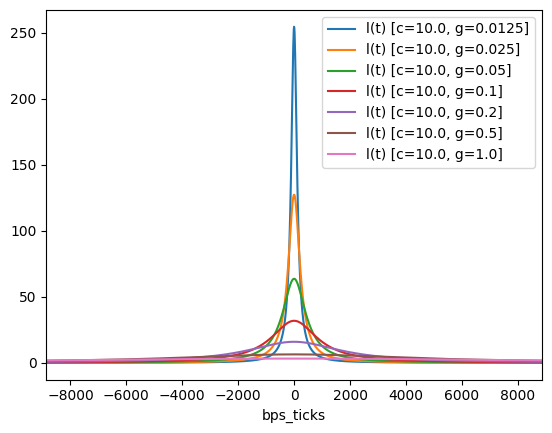

In [14]:
df.plot(x='bps_ticks', y=[f'l(t) [c={C}, g={g}]' for g in gammas], xlim=(-MAX_TICK // 100, MAX_TICK // 100))

<Axes: xlabel='bps_ticks'>

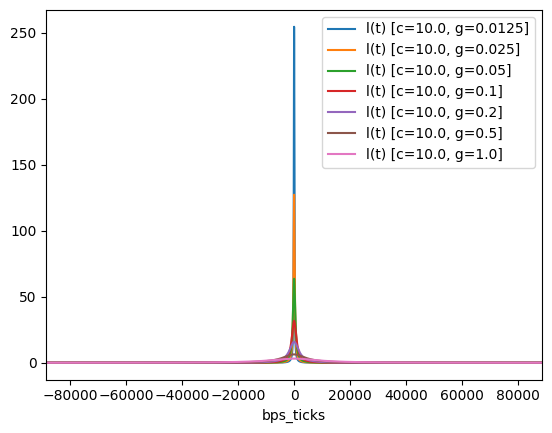

In [15]:
df.plot(x='bps_ticks', y=[f'l(t) [c={C}, g={g}]' for g in gammas], xlim=(-MAX_TICK // 10, MAX_TICK // 10))

In [16]:
# generate for more global liquidity constant values
cs = np.array([1.0, 2.5, 5.0, 10.0, 20.0, 40.0])

In [17]:
for c in cs:
    df[f'l(t) [c={c}, g={GAMMA}]'] = CauchyLiquidityProfile(c=c, gamma=GAMMA).at(log_ticks)

In [18]:
df

,bps_ticks,log_ticks,"l(t) [c=10.0, g=0.1]","l(t) [c=10.0, g=0.0125]","l(t) [c=10.0, g=0.025]","l(t) [c=10.0, g=0.05]","l(t) [c=10.0, g=0.2]","l(t) [c=10.0, g=0.5]","l(t) [c=10.0, g=1.0]","l(t) [c=1.0, g=0.1]","l(t) [c=2.5, g=0.1]","l(t) [c=5.0, g=0.1]","l(t) [c=20.0, g=0.1]","l(t) [c=40.0, g=0.1]"
0,-887272,-88.722764,0.00004,0.000005,0.00001,0.00002,0.000081,0.000202,0.000404,0.000004,0.00001,0.00002,0.000081,0.000162
1,-887262,-88.721764,0.00004,0.000005,0.00001,0.00002,0.000081,0.000202,0.000404,0.000004,0.00001,0.00002,0.000081,0.000162
2,-887252,-88.720764,0.00004,0.000005,0.00001,0.00002,0.000081,0.000202,0.000404,0.000004,0.00001,0.00002,0.000081,0.000162
3,-887242,-88.719764,0.00004,0.000005,0.00001,0.00002,0.000081,0.000202,0.000404,0.000004,0.00001,0.00002,0.000081,0.000162
4,-887232,-88.718764,0.00004,0.000005,0.00001,0.00002,0.000081,0.000202,0.000404,0.000004,0.00001,0.00002,0.000081,0.000162
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
177450,887228,88.718364,0.00004,0.000005,0.00001,0.00002,0.000081,0.000202,0.000404,0.000004,0.00001,0.00002,0.000081,0.000162
177451,887238,88.719364,0.00004,0.000005,0.00001,0.00002,0.000081,0.000202,0.000404,0.000004,0.00001,0.00002,0.000081,0.000162
177452,887248,88.720364,0.00004,0.000005,0.00001,0.00002,0.000081,0.000202,0.000404,0.000004,0.00001,0.00002,0.000081,0.000162
177453,887258,88.721364,0.00004,0.000005,0.00001,0.00002,0.000081,0.000202,0.000404,0.000004,0.00001,0.00002,0.000081,0.000162


<Axes: xlabel='bps_ticks'>

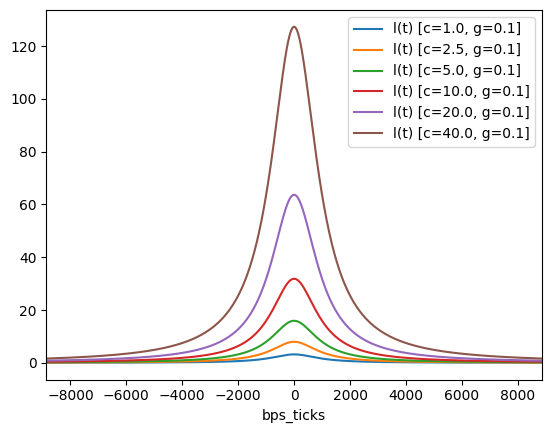

In [19]:
df.plot(x='bps_ticks', y=[f'l(t) [c={c}, g={GAMMA}]' for c in cs], xlim=(-MAX_TICK // 100, MAX_TICK // 100))

In [20]:
# examine slippage for base Cauchy case of C, GAMMA
df[f'dt/dy [c={C}, g={GAMMA}]'] = clp.slip_y(log_ticks)
df[f'dt/dx [c={C}, g={GAMMA}]'] = clp.slip_x(log_ticks)

<Axes: xlabel='bps_ticks'>

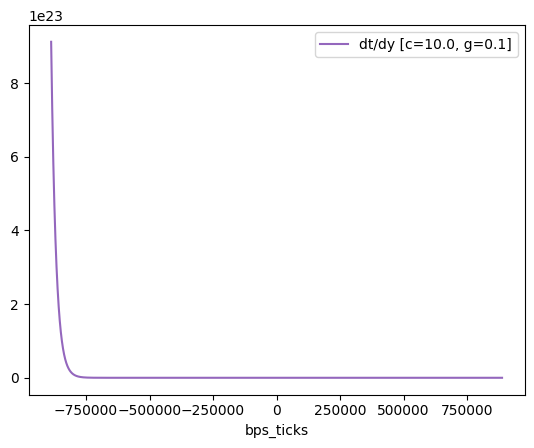

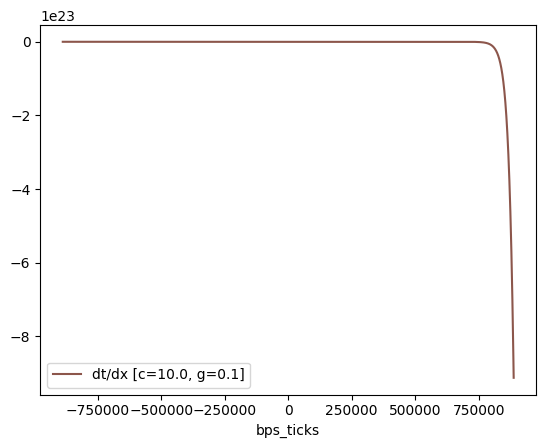

In [21]:
# plot y and x slippage across all ticks
df.plot(x='bps_ticks', y=f'dt/dy [c={C}, g={GAMMA}]', color='C4')
df.plot(x='bps_ticks', y=f'dt/dx [c={C}, g={GAMMA}]', color='C5')

In [22]:
df[f'dt/dy [c={C}, g={GAMMA}]']

0         9.123342e+23
1         9.118576e+23
2         9.113813e+23
3         9.109052e+23
4         9.104293e+23
              ...     
177450    2.686949e-15
177451    2.685667e-15
177452    2.684385e-15
177453    2.683104e-15
177454    2.681823e-15
Name: dt/dy [c=10.0, g=0.1], Length: 177455, dtype: float64

In [23]:
# if pool is 10 bps away from p=1, and swap in 10% of liquidity in y
# should expect tick to increase by ~6% to 10.63 bps away
(0.1 * clp.c) * clp.slip_y(from_bps_tick(10))

0.06280672598454913

<Axes: xlabel='bps_ticks'>

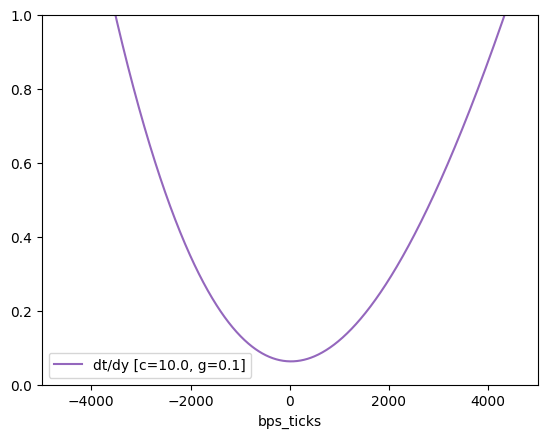

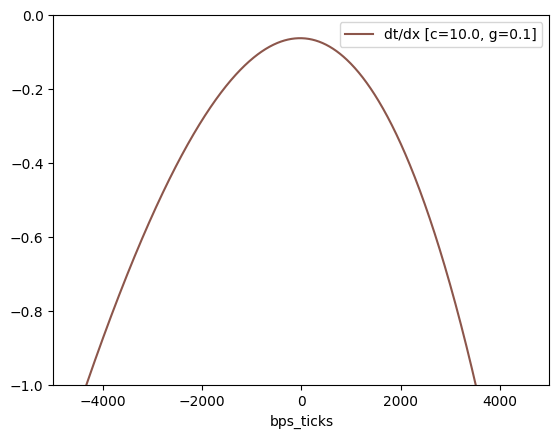

In [24]:
# plot y and x slippage across near tick=0 to +/-50%
# slippage accelerates as move toward price extremes, but bottoms as approach tick=0
df.plot(x='bps_ticks', y=f'dt/dy [c={C}, g={GAMMA}]', color='C4', xlim=(-5000, 5000), ylim=(0, 1.0))
df.plot(x='bps_ticks', y=f'dt/dx [c={C}, g={GAMMA}]', color='C5', xlim=(-5000, 5000), ylim=(-1.0, 0))

<Axes: xlabel='bps_ticks'>

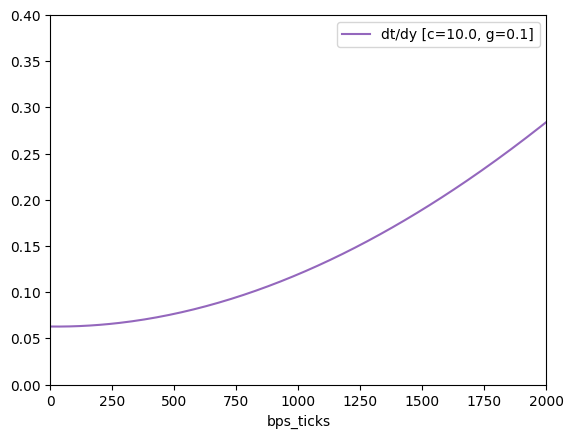

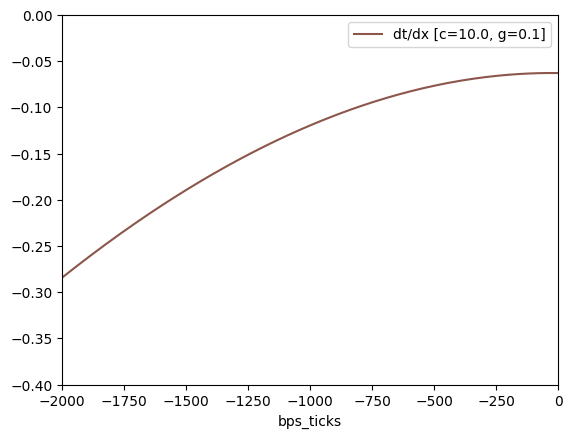

In [25]:
# plot y and x slippage from tick=0 to +/-20%
df.plot(x='bps_ticks', y=f'dt/dy [c={C}, g={GAMMA}]', color='C4', xlim=(0, 2000), ylim=(0, 0.4))
df.plot(x='bps_ticks', y=f'dt/dx [c={C}, g={GAMMA}]', color='C5', xlim=(-2000, 0), ylim=(-0.4, 0))

In [26]:
# look at slippage curves for different gamma values
for g in gammas:
    df[f'dt/dy [c={C}, g={g}]'] = CauchyLiquidityProfile(c=C, gamma=g).slip_y(log_ticks)
    df[f'dt/dx [c={C}, g={g}]'] = CauchyLiquidityProfile(c=C, gamma=g).slip_x(log_ticks)

In [27]:
df

,bps_ticks,log_ticks,"l(t) [c=10.0, g=0.1]","l(t) [c=10.0, g=0.0125]","l(t) [c=10.0, g=0.025]","l(t) [c=10.0, g=0.05]","l(t) [c=10.0, g=0.2]","l(t) [c=10.0, g=0.5]","l(t) [c=10.0, g=1.0]","l(t) [c=1.0, g=0.1]",...,"dt/dy [c=10.0, g=0.025]","dt/dx [c=10.0, g=0.025]","dt/dy [c=10.0, g=0.05]","dt/dx [c=10.0, g=0.05]","dt/dy [c=10.0, g=0.2]","dt/dx [c=10.0, g=0.2]","dt/dy [c=10.0, g=0.5]","dt/dx [c=10.0, g=0.5]","dt/dy [c=10.0, g=1.0]","dt/dx [c=10.0, g=1.0]"
0,-887272,-88.722764,0.00004,0.000005,0.00001,0.00002,0.000081,0.000202,0.000404,0.000004,...,3.649332e+24,-1.072523e-14,1.824667e+24,-5.362616e-15,4.561688e+23,-1.340660e-15,1.824724e+23,-5.362785e-16,9.124489e+22,-2.681648e-16
1,-887262,-88.721764,0.00004,0.000005,0.00001,0.00002,0.000081,0.000202,0.000404,0.000004,...,3.647426e+24,-1.073035e-14,1.823713e+24,-5.365177e-15,4.559305e+23,-1.341301e-15,1.823771e+23,-5.365346e-16,9.119723e+22,-2.682929e-16
2,-887252,-88.720764,0.00004,0.000005,0.00001,0.00002,0.000081,0.000202,0.000404,0.000004,...,3.645521e+24,-1.073548e-14,1.822761e+24,-5.367739e-15,4.556924e+23,-1.341941e-15,1.822818e+23,-5.367908e-16,9.114959e+22,-2.684210e-16
3,-887242,-88.719764,0.00004,0.000005,0.00001,0.00002,0.000081,0.000202,0.000404,0.000004,...,3.643616e+24,-1.074060e-14,1.821809e+24,-5.370303e-15,4.554543e+23,-1.342582e-15,1.821866e+23,-5.370472e-16,9.110197e+22,-2.685492e-16
4,-887232,-88.718764,0.00004,0.000005,0.00001,0.00002,0.000081,0.000202,0.000404,0.000004,...,3.641713e+24,-1.074573e-14,1.820857e+24,-5.372867e-15,4.552164e+23,-1.343223e-15,1.820914e+23,-5.373036e-16,9.105438e+22,-2.686774e-16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
177450,887228,88.718364,0.00004,0.000005,0.00001,0.00002,0.000081,0.000202,0.000404,0.000004,...,1.074778e-14,-3.640952e+24,5.373893e-15,-1.820476e+24,1.343480e-15,-4.551213e+23,5.374062e-16,-1.820534e+23,2.687287e-16,-9.103536e+22
177451,887238,88.719364,0.00004,0.000005,0.00001,0.00002,0.000081,0.000202,0.000404,0.000004,...,1.074265e-14,-3.642855e+24,5.371328e-15,-1.821428e+24,1.342839e-15,-4.553591e+23,5.371497e-16,-1.821485e+23,2.686005e-16,-9.108293e+22
177452,887248,88.720364,0.00004,0.000005,0.00001,0.00002,0.000081,0.000202,0.000404,0.000004,...,1.073753e-14,-3.644759e+24,5.368765e-15,-1.822380e+24,1.342198e-15,-4.555971e+23,5.368933e-16,-1.822437e+23,2.684722e-16,-9.113054e+22
177453,887258,88.721364,0.00004,0.000005,0.00001,0.00002,0.000081,0.000202,0.000404,0.000004,...,1.073240e-14,-3.646664e+24,5.366202e-15,-1.823332e+24,1.341557e-15,-4.558353e+23,5.366371e-16,-1.823390e+23,2.683441e-16,-9.117817e+22


<Axes: xlabel='bps_ticks'>

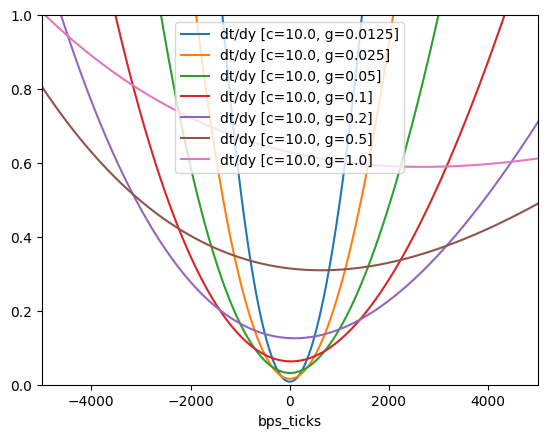

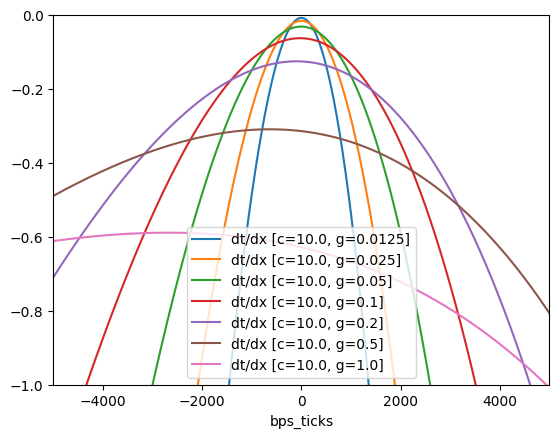

In [28]:
# plot y and x slippage across near tick=0 to +/-50% for multiple gammas
# slippage accelerates quicker at smaller tick deltas for lower gamma values (higher leverage near tick=0) 
df.plot(x='bps_ticks', y=[f'dt/dy [c={C}, g={g}]' for g in gammas], xlim=(-5000, 5000), ylim=(0, 1.0))
df.plot(x='bps_ticks', y=[f'dt/dx [c={C}, g={g}]' for g in gammas], xlim=(-5000, 5000), ylim=(-1.0, 0))

<Axes: xlabel='bps_ticks'>

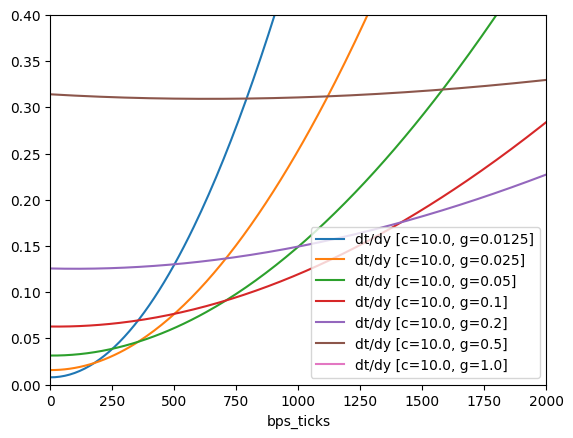

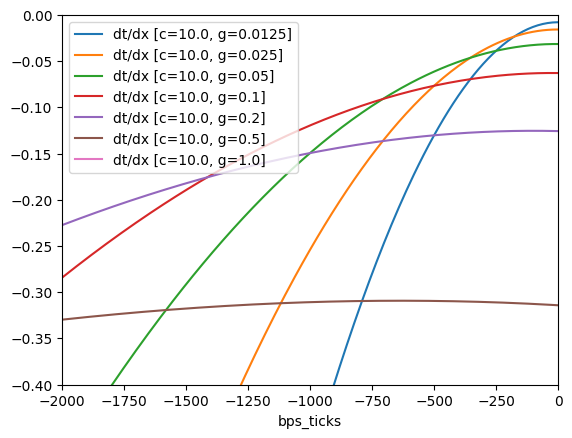

In [29]:
# plot y and x slippage from tick=0 to +/-20% for multiple gammas
# lower gamma appropriate for pairs where expect most price action within smaller tick range around tick=0
df.plot(x='bps_ticks', y=[f'dt/dy [c={C}, g={g}]' for g in gammas], xlim=(0, 2000), ylim=(0, 0.4))
df.plot(x='bps_ticks', y=[f'dt/dx [c={C}, g={g}]' for g in gammas], xlim=(-2000, 0), ylim=(-0.4, 0))

In [30]:
# look at slippage curves for different global liquidity constant values
for c in cs:
    df[f'dt/dy [c={c}, g={GAMMA}]'] = CauchyLiquidityProfile(c=c, gamma=GAMMA).slip_y(log_ticks)
    df[f'dt/dx [c={c}, g={GAMMA}]'] = CauchyLiquidityProfile(c=c, gamma=GAMMA).slip_x(log_ticks)

In [31]:
df

,bps_ticks,log_ticks,"l(t) [c=10.0, g=0.1]","l(t) [c=10.0, g=0.0125]","l(t) [c=10.0, g=0.025]","l(t) [c=10.0, g=0.05]","l(t) [c=10.0, g=0.2]","l(t) [c=10.0, g=0.5]","l(t) [c=10.0, g=1.0]","l(t) [c=1.0, g=0.1]",...,"dt/dy [c=1.0, g=0.1]","dt/dx [c=1.0, g=0.1]","dt/dy [c=2.5, g=0.1]","dt/dx [c=2.5, g=0.1]","dt/dy [c=5.0, g=0.1]","dt/dx [c=5.0, g=0.1]","dt/dy [c=20.0, g=0.1]","dt/dx [c=20.0, g=0.1]","dt/dy [c=40.0, g=0.1]","dt/dx [c=40.0, g=0.1]"
0,-887272,-88.722764,0.00004,0.000005,0.00001,0.00002,0.000081,0.000202,0.000404,0.000004,...,9.123342e+24,-2.681311e-14,3.649337e+24,-1.072524e-14,1.824668e+24,-5.362621e-15,4.561671e+23,-1.340655e-15,2.280835e+23,-6.703277e-16
1,-887262,-88.721764,0.00004,0.000005,0.00001,0.00002,0.000081,0.000202,0.000404,0.000004,...,9.118576e+24,-2.682591e-14,3.647430e+24,-1.073036e-14,1.823715e+24,-5.365182e-15,4.559288e+23,-1.341296e-15,2.279644e+23,-6.706478e-16
2,-887252,-88.720764,0.00004,0.000005,0.00001,0.00002,0.000081,0.000202,0.000404,0.000004,...,9.113813e+24,-2.683872e-14,3.645525e+24,-1.073549e-14,1.822763e+24,-5.367745e-15,4.556906e+23,-1.341936e-15,2.278453e+23,-6.709681e-16
3,-887242,-88.719764,0.00004,0.000005,0.00001,0.00002,0.000081,0.000202,0.000404,0.000004,...,9.109052e+24,-2.685154e-14,3.643621e+24,-1.074062e-14,1.821810e+24,-5.370308e-15,4.554526e+23,-1.342577e-15,2.277263e+23,-6.712885e-16
4,-887232,-88.718764,0.00004,0.000005,0.00001,0.00002,0.000081,0.000202,0.000404,0.000004,...,9.104293e+24,-2.686436e-14,3.641717e+24,-1.074574e-14,1.820859e+24,-5.372872e-15,4.552147e+23,-1.343218e-15,2.276073e+23,-6.716091e-16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
177450,887228,88.718364,0.00004,0.000005,0.00001,0.00002,0.000081,0.000202,0.000404,0.000004,...,2.686949e-14,-9.102391e+24,1.074780e-14,-3.640956e+24,5.373899e-15,-1.820478e+24,1.343475e-15,-4.551195e+23,6.717373e-16,-2.275598e+23
177451,887238,88.719364,0.00004,0.000005,0.00001,0.00002,0.000081,0.000202,0.000404,0.000004,...,2.685667e-14,-9.107148e+24,1.074267e-14,-3.642859e+24,5.371334e-15,-1.821430e+24,1.342833e-15,-4.553574e+23,6.714167e-16,-2.276787e+23
177452,887248,88.720364,0.00004,0.000005,0.00001,0.00002,0.000081,0.000202,0.000404,0.000004,...,2.684385e-14,-9.111908e+24,1.073754e-14,-3.644763e+24,5.368770e-15,-1.822382e+24,1.342192e-15,-4.555954e+23,6.710962e-16,-2.277977e+23
177453,887258,88.721364,0.00004,0.000005,0.00001,0.00002,0.000081,0.000202,0.000404,0.000004,...,2.683104e-14,-9.116670e+24,1.073241e-14,-3.646668e+24,5.366207e-15,-1.823334e+24,1.341552e-15,-4.558335e+23,6.707759e-16,-2.279168e+23


<Axes: xlabel='bps_ticks'>

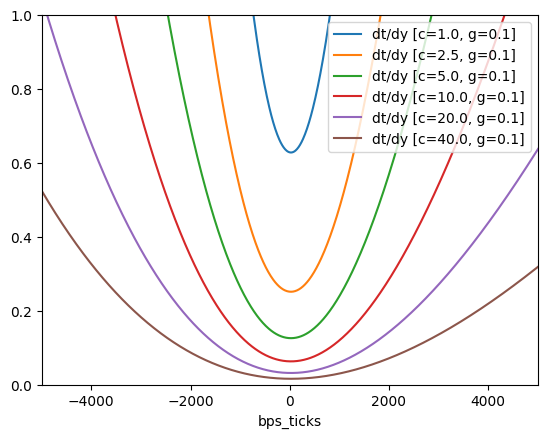

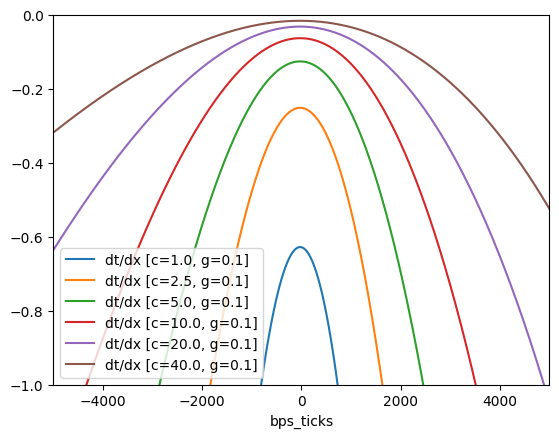

In [32]:
# plot y and x slippage across near tick=0 to +/-50% for multiple liquidity constants
# higher liquidity constant also means less slippage acceleration once moves away from tick=0 range
df.plot(x='bps_ticks', y=[f'dt/dy [c={c}, g={GAMMA}]' for c in cs], xlim=(-5000, 5000), ylim=(0, 1.0))
df.plot(x='bps_ticks', y=[f'dt/dx [c={c}, g={GAMMA}]' for c in cs], xlim=(-5000, 5000), ylim=(-1.0, 0))

<Axes: xlabel='bps_ticks'>

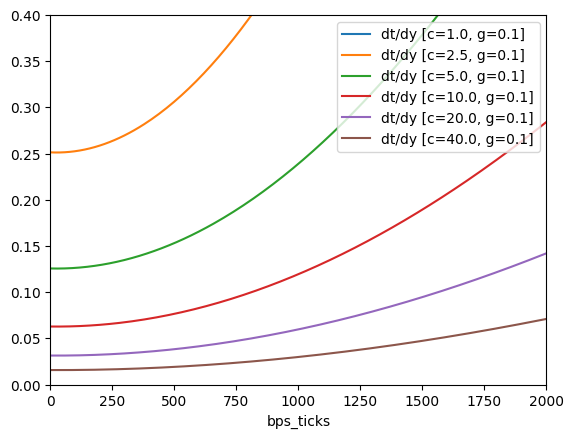

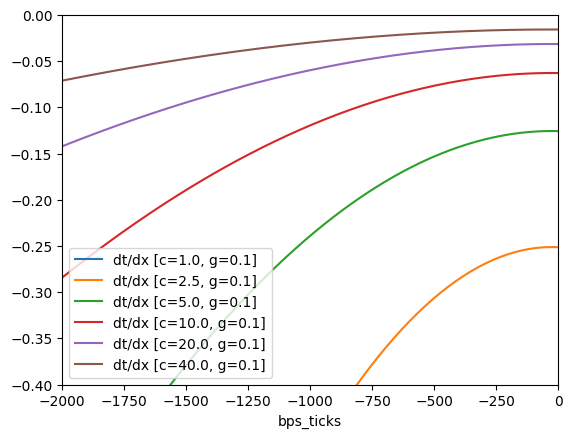

In [33]:
# plot y and x slippage from tick=0 to +/-20% for multiple liquidity constants
# more global liquidity seems to also translate to wider bottoming out of slippage near tick=0
df.plot(x='bps_ticks', y=[f'dt/dy [c={c}, g={GAMMA}]' for c in cs], xlim=(0, 2000), ylim=(0, 0.4))
df.plot(x='bps_ticks', y=[f'dt/dx [c={c}, g={GAMMA}]' for c in cs], xlim=(-2000, 0), ylim=(-0.4, 0))

In [34]:
# as gamma decreases, higher leverage around tick=0 implies larger amount of capital needed to move pool price
#  ... gamma=0.0125: to move tick 0.1% higher from 0, need to swap in to pool ~1.27% of y reserves for cost leverage of 12.7x
#  ... gamma=0.1: to move tick 0.1% higher from 0, need to swap in to pool ~0.15% of y reserves for cost leverage of 1.5x

# with tradeoff that as pool price moves further away from tick=0, lower gamma results in faster drop off in
# cost of capital to move pool per unit of tick change
#  ... gamma=0.0125: to move tick 0.1% higher from tick=500 to tick=510, cost leverage of 0.75x
#  ... gamma=0.1: to move tick 0.1% higher from tick=500 to tick=510, cost leverage of 1.3x

width = 10  # bps (0.1%)
top = 1000  # bps (10%)
tick_ranges = [(width * i, width * (i+1)) for i in range(top // width)]
for i, f in tick_ranges:
    for g in gammas:
        cost_y_rel = CauchyLiquidityProfile(c=C, gamma=g).cost_y(from_bps_tick(i), from_bps_tick(f)) / clp.c
        cost_y_rel_bps = cost_y_rel * 1e4
        cost_lev = cost_y_rel_bps / width
        print(f"(i, f): ({i}, {f}); g: {g}; cost y rel to clp.c in bps: {cost_y_rel_bps}; cost leverage: {cost_lev}") 

(i, f): (0, 10); g: 0.0125; cost y rel to clp.c in bps: 127.0787747212436; cost leverage: 12.70787747212436
(i, f): (0, 10); g: 0.025; cost y rel to clp.c in bps: 63.640782774100664; cost leverage: 6.364078277410067
(i, f): (0, 10); g: 0.05; cost y rel to clp.c in bps: 31.833111384401562; cost leverage: 3.183311138440156
(i, f): (0, 10); g: 0.1; cost y rel to clp.c in bps: 15.918147122356972; cost leverage: 1.5918147122356971
(i, f): (0, 10); g: 0.2; cost y rel to clp.c in bps: 7.959272534701018; cost leverage: 0.7959272534701018
(i, f): (0, 10); g: 0.5; cost y rel to clp.c in bps: 3.1837313001984513; cost leverage: 0.31837313001984513
(i, f): (0, 10); g: 1.0; cost y rel to clp.c in bps: 1.591867242002008; cost leverage: 0.1591867242002008
(i, f): (10, 20); g: 0.0125; cost y rel to clp.c in bps: 125.54225464447977; cost leverage: 12.554225464447978
(i, f): (10, 20); g: 0.025; cost y rel to clp.c in bps: 63.469734203461016; cost leverage: 6.346973420346101
(i, f): (10, 20); g: 0.05; cos